https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/President_Barack_Obama.jpg/1200px-President_Barack_Obama.jpg
--2022-03-03 17:00:36--  https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/President_Barack_Obama.jpg/1200px-President_Barack_Obama.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 308833 (302K) [image/jpeg]
Saving to: ‘src.jpg’

src.jpg             100%[===================>] 301.59K  --.-KB/s    in 0.1s    

2022-03-03 17:00:37 (2.93 MB/s) - ‘src.jpg’ saved [308833/308833]



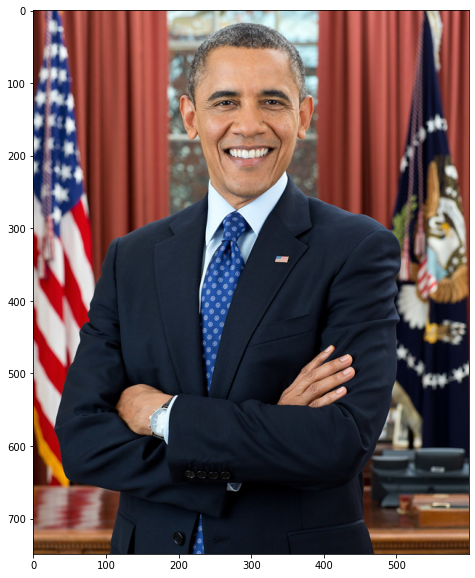

In [11]:
#@title 下載 src 圖檔

import os
from PIL import Image
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/President_Barack_Obama.jpg/1200px-President_Barack_Obama.jpg' #@param {type:"string"}
print(url)
cmd=f"wget {url} -O src.jpg"  
! $cmd 

if os.path.isfile('src.jpg'):
  im = Image.open('src.jpg')
  w_ = 600
  h_ = int((w_ / im.width) * im.height)  
  new_img = im.resize((w_,h_))
  plt.figure(figsize = (20,10))
  plt.imshow(new_img)



https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Donald_Trump_official_portrait.jpg/1200px-Donald_Trump_official_portrait.jpg
--2022-03-03 17:00:39--  https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Donald_Trump_official_portrait.jpg/1200px-Donald_Trump_official_portrait.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 458571 (448K) [image/jpeg]
Saving to: ‘dst.jpg’

dst.jpg             100%[===================>] 447.82K  --.-KB/s    in 0.1s    

2022-03-03 17:00:39 (3.78 MB/s) - ‘dst.jpg’ saved [458571/458571]



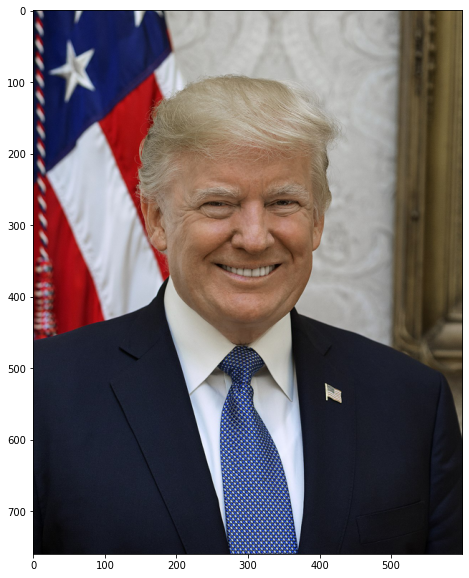

In [12]:
#@title 下載 dst 圖檔

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Donald_Trump_official_portrait.jpg/1200px-Donald_Trump_official_portrait.jpg' #@param {type:"string"}
print(url)
cmd=f"wget {url} -O dst.jpg"  
! $cmd 

if os.path.isfile('dst.jpg'):
  im = Image.open('dst.jpg')
  w_ = 600
  h_ = int((w_ / im.width) * im.height)  
  new_img = im.resize((w_,h_))
  plt.figure(figsize = (20,10))
  plt.imshow(new_img)


In [13]:
#@markdown 讀取圖片

import cv2
import dlib
import numpy as np
from matplotlib import pyplot as plt
src = cv2.imread("src.jpg")
dst = cv2.imread("dst.jpg")
src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)

# Create empty matrices in the images' shapes
height, width = src_gray.shape
mask = np.zeros((height, width), np.uint8)

height, width, channels = dst.shape

In [16]:
#@markdown 下載臉部區域識別模型
if not os.path.exists('shape_predictor_68_face_landmarks.dat'):
  ! wget https://sourceforge.net/projects/dclib/files/dlib/v18.10/shape_predictor_68_face_landmarks.dat.bz2/download -O shape_predictor_68_face_landmarks.dat.bz2
  ! bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

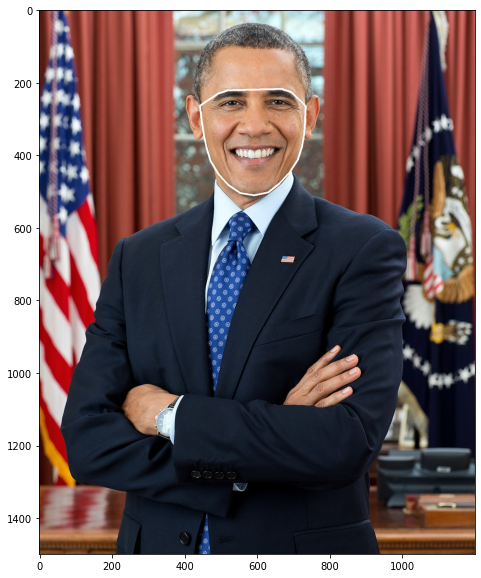

In [17]:
#@markdown 取得 src 臉部 Landmark

# Loading models and predictors of the dlib library to detect landmarks in both faces
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")

# Getting landmarks for the face that will be swapped into to the body
rect = detector(src_gray)[0]

# This creates a with 68 pairs of integer values — these values are the (x, y)-coordinates of the facial structures 
landmarks = predictor(src_gray, rect)
landmarks_points = [] 

def get_landmarks(landmarks, landmarks_points):
  for n in range(68):
      x = landmarks.part(n).x
      y = landmarks.part(n).y
      landmarks_points.append((x, y))

get_landmarks(landmarks, landmarks_points)

points = np.array(landmarks_points, np.int32)
convexhull = cv2.convexHull(points) 

src_cp = src.copy()
plt.figure(figsize = (20,10))
plt.imshow(cv2.cvtColor((cv2.polylines(src_cp, [convexhull], True, (255,255,255), 3)), cv2.COLOR_BGR2RGB))

src_image_1 = cv2.bitwise_and(src, src, mask=mask)

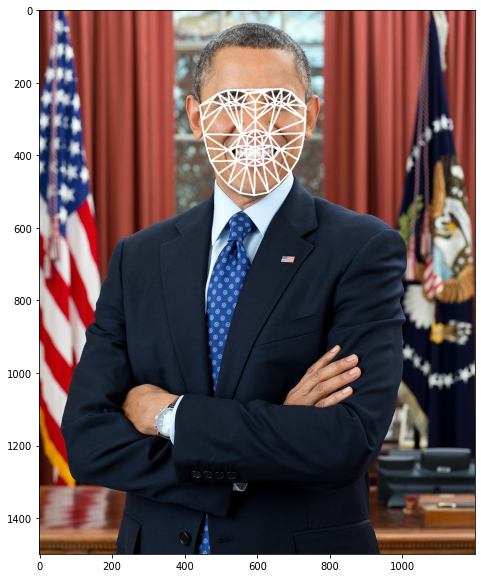

In [18]:
#@markdown 取得 src 臉部Triangle
rect = cv2.boundingRect(convexhull)

subdiv = cv2.Subdiv2D(rect) # Creates an instance of Subdiv2D
subdiv.insert(landmarks_points) # Insert points into subdiv
triangles = subdiv.getTriangleList()
triangles = np.array(triangles, dtype=np.int32)

indexes_triangles = []
src_cp = src.copy()

def get_index(arr):
    index = 0
    if arr[0]:
        index = arr[0][0]
    return index

for triangle in triangles :

    # Gets the vertex of the triangle
    pt1 = (triangle[0], triangle[1])
    pt2 = (triangle[2], triangle[3])
    pt3 = (triangle[4], triangle[5])
    
    # Draws a line for each side of the triangle
    cv2.line(src_cp, pt1, pt2, (255, 255, 255), 3,  0)
    cv2.line(src_cp, pt2, pt3, (255, 255, 255), 3,  0)
    cv2.line(src_cp, pt3, pt1, (255, 255, 255), 3,  0)

    index_pt1 = np.where((points == pt1).all(axis=1))
    index_pt1 = get_index(index_pt1)
    index_pt2 = np.where((points == pt2).all(axis=1))
    index_pt2 = get_index(index_pt2)
    index_pt3 = np.where((points == pt3).all(axis=1))
    index_pt3 = get_index(index_pt3)

    # Saves coordinates if the triangle exists and has 3 vertices
    if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
        vertices = [index_pt1, index_pt2, index_pt3]
        indexes_triangles.append(vertices)

# Draw delaunay triangles
plt.figure(figsize = (20,10))
plt.imshow(cv2.cvtColor(src_cp, cv2.COLOR_BGR2RGB))  

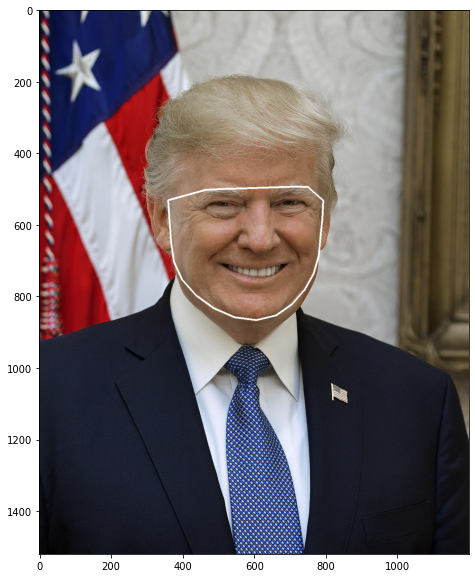

In [19]:
#@markdown 取得 dst 臉部 Landmark
# Getting landmarks for the face that will have the first one swapped into
rect2 = detector(dst_gray)[0]

# This creates a with 68 pairs of integer values — these values are the (x, y)-coordinates of the facial structures 
landmarks_2 = predictor(dst_gray, rect2)
landmarks_points2 = []

# Uses the function declared previously to get a list of the landmark coordinates
get_landmarks(landmarks_2, landmarks_points2)

# Generates a convex hull for the second person
points2 = np.array(landmarks_points2, np.int32)
convexhull2 = cv2.convexHull(points2)

dst_cp = dst.copy()
plt.figure(figsize = (20,10))
plt.imshow(cv2.cvtColor((cv2.polylines(dst_cp, [convexhull2], True, (255,255,255), 3)), cv2.COLOR_BGR2RGB))

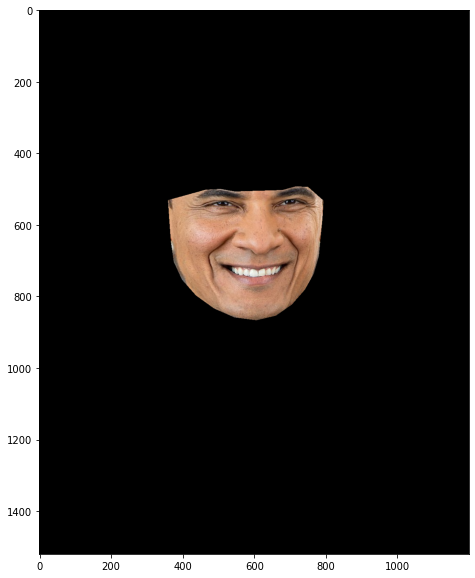

In [20]:
#@markdown 取得 Target 遮罩
lines_space_new_face = np.zeros((height, width, channels), np.uint8)
dst_new_face = np.zeros((height, width, channels), np.uint8)

height, width = src_gray.shape
lines_space_mask = np.zeros((height, width), np.uint8)


for triangle in indexes_triangles:

    # Coordinates of the first person's delaunay triangles
    pt1 = landmarks_points[triangle[0]]
    pt2 = landmarks_points[triangle[1]]
    pt3 = landmarks_points[triangle[2]]

    # Gets the delaunay triangles
    (x, y, widht, height) = cv2.boundingRect(np.array([pt1, pt2, pt3], np.int32))
    cropped_triangle = src[y: y+height, x: x+widht]
    cropped_mask = np.zeros((height, widht), np.uint8)

    # Fills triangle to generate the mask
    points = np.array([[pt1[0]-x, pt1[1]-y], [pt2[0]-x, pt2[1]-y], [pt3[0]-x, pt3[1]-y]], np.int32)
    cv2.fillConvexPoly(cropped_mask, points, 255)

    # Draws lines for the triangles
    cv2.line(lines_space_mask, pt1, pt2, 255)
    cv2.line(lines_space_mask, pt2, pt3, 255)
    cv2.line(lines_space_mask, pt1, pt3, 255)

    lines_space = cv2.bitwise_and(src, src, mask=lines_space_mask)

    # Calculates the delaunay triangles of the second person's face

    # Coordinates of the first person's delaunay triangles
    pt1 = landmarks_points2[triangle[0]]
    pt2 = landmarks_points2[triangle[1]]
    pt3 = landmarks_points2[triangle[2]]

    # Gets the delaunay triangles
    (x, y, widht, height) = cv2.boundingRect(np.array([pt1, pt2, pt3], np.int32))
    cropped_mask2 = np.zeros((height,widht), np.uint8)

    # Fills triangle to generate the mask
    points2 = np.array([[pt1[0]-x, pt1[1]-y], [pt2[0]-x, pt2[1]-y], [pt3[0]-x, pt3[1]-y]], np.int32)
    cv2.fillConvexPoly(cropped_mask2, points2, 255)

    # Deforms the triangles to fit the subject's face : https://docs.opencv.org/3.4/d4/d61/tutorial_warp_affine.html
    points =  np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)  # Warps the content of the first triangle to fit in the second one
    dist_triangle = cv2.warpAffine(cropped_triangle, M, (widht, height))
    dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=cropped_mask2)

    # Joins all the distorted triangles to make the face mask to fit in the second person's features
    dst_new_face_rect_area = dst_new_face[y: y+height, x: x+widht]
    dst_new_face_rect_area_gray = cv2.cvtColor(dst_new_face_rect_area, cv2.COLOR_BGR2GRAY)

    # Creates a mask
    masked_triangle = cv2.threshold(dst_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=masked_triangle[1])

    # Adds the piece to the face mask
    dst_new_face_rect_area = cv2.add(dst_new_face_rect_area, dist_triangle)
    dst_new_face[y: y+height, x: x+widht] = dst_new_face_rect_area
plt.figure(figsize = (20,10))
plt.imshow(cv2.cvtColor(dst_new_face, cv2.COLOR_BGR2RGB))

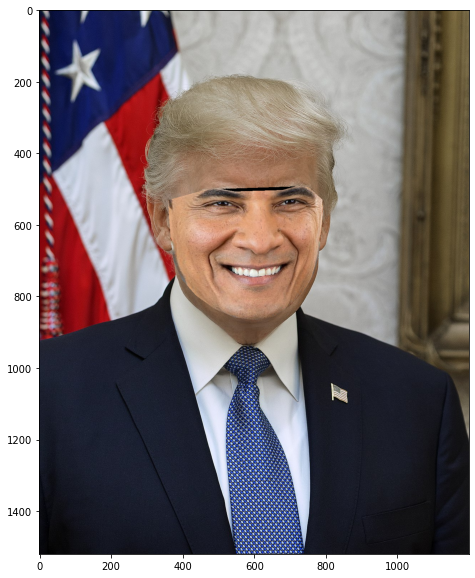

In [21]:
#@markdown 交換 A 與 B 的臉
dst_face_mask = np.zeros_like(dst_gray)
dst_head_mask = cv2.fillConvexPoly(dst_face_mask, convexhull2, 255)
dst_face_mask = cv2.bitwise_not(dst_head_mask)

dst_maskless = cv2.bitwise_and(dst, dst, mask=dst_face_mask)
result = cv2.add(dst_maskless, dst_new_face)

plt.figure(figsize = (20,10))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))